This is a simple implementation of a Deep Q Network learning agent tested on Open AI Gym's cart pole.
With some hyper parameter changes it should be able to learn all the Box2d environments of open AI gym as the agent is non-specifc to it (just depends on the action space and obervation space of the environment which are set automatically in __init__).
The implementation is in accrodance with the article by Gaetan: https://medium.com/@gtnjuvin/my-journey-into-deep-q-learning-with-keras-and-gym-3e779cc12762

Import some stuff

In [1]:
import gym
import tensorflow as tf
import tensorboard
import numpy as np
import datetime
from collections import deque
import random
from IPython.display import clear_output
from matplotlib import pyplot as plt
get_ipython().run_line_magic('matplotlib', 'inline')

Define the agent class. This contains everything including the brain (Dense Neural network) that reqpresents the Q(S,A) value function approximation.

In [2]:

class DQN_Agent():
    def __init__(self,env):
        self.weight_backup = 'DQN_Agent_Cartpole_'+ datetime.datetime.now().strftime("%Y-%m-%d_%H:%M:%S")+'.h5'
        self.learning_rate = 0.001
        self.gamma = 0.95
        self.exploration_rate = 1.0
        self.exploration_min = 0.01
        self.expolration_decay = 0.995
        self.action_space = env.action_space.n
        self.state_space = env.observation_space.shape[0]
        self.memory = deque(maxlen=2000)

        self.model = tf.keras.Sequential([
        tf.keras.layers.Dense(24,input_dim=self.state_space,activation = 'relu'),
        #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24,activation = 'relu'),
        tf.keras.layers.Dense(self.action_space,activation = 'linear')
        ])
        #call compile
        self.model.compile(
            loss='mse',
            optimizer = tf.keras.optimizers.Adam(lr=self.learning_rate)
        )


    def save_model(self):
        self.model.save(self.weight_backup)


    def act(self,state,override_random = False):
        if np.random.rand() <= self.exploration_rate and not override_random:
            return np.random.randint(self.action_space)
        act_values = self.model.predict(state)
        return np.argmax(act_values[0])


    def remember(self,state,action,reward,next_state,done):
        self.memory.append((state,action,reward,next_state,done))


    def replay(self,sample_batch_size):
        if len(self.memory) < sample_batch_size: #dont start sampling before queue has enough samples
            return
        sample_batch = random.sample(self.memory, sample_batch_size)
        for state, action, reward, next_state, done in sample_batch:
            #print(f"{state.T} {state.shape} {next_state.T} {next_state.shape}")
            if not done:
                target = reward + self.gamma * np.amax(self.model.predict(next_state)[0])
            else:
                target = reward
            target_f = self.model.predict(state)
            target_f[0][action] = target
            self.model.fit(state,target_f,epochs=1,verbose=0)
        if self.exploration_rate > self.exploration_min:
            self.exploration_rate *= self.expolration_decay


Below is the main call. It runs a defined numer of episodes, fills the replay buffer and calls the "replay" method once every episode which does the actual learning (fitting of the neural network to the results)

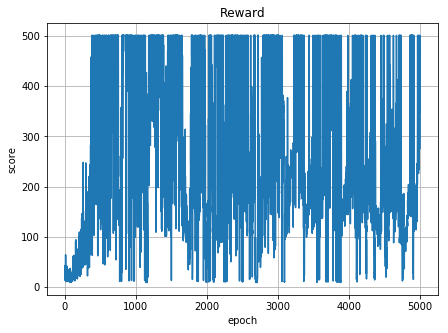

OSError: Unable to create file (unable to open file: name = 'DQN_Agent_Cartpole_2019-03-18_09:57:10.h5', errno = 22, error message = 'Invalid argument', flags = 13, o_flags = 302)

In [3]:

#----------------------MAIN---------------------
ENV_NAME            = 'CartPole-v1'
EPISODES            = 5000
SAMPLE_BATCH_SIZE   = 32

#create environment and agent
env = gym.make(ENV_NAME)
agent = DQN_Agent(env)

def Live_plot(data,figsize=(7,5),title='Reward'):
    """ 
    A simple "dynamic" pyplot for showing the rewards during training.
    Args: 
       :data: the data to plot (simple 1d list)
    """
    clear_output(wait=True)
    plt.figure(figsize = figsize)
    plt.plot(data)
    plt.title(title)
    plt.grid(True)
    plt.xlabel('epoch')
    plt.ylabel('score')
    plt.show()

results_lst = []

for episode in range(EPISODES):
    state = env.reset()
    state = np.reshape(state,[1,agent.state_space])
    done = False
    index = 0
    while not done:
        action = agent.act(state) #get action, play epsion greedy
        next_state, reward, done, _ = env.step(action) #use action to get S'R from env
        next_state = np.reshape(next_state,[1,agent.state_space]) #don't understand why but otherwise tf.keras does sometimes not like the shape
        agent.remember(state, action, reward, next_state, done) #add tuple to memory buffer
        state = next_state
        index += 1
        if episode % 50 == 0: #render sometimes against bordom
            env.render()
    #if episode % 50 == 0: #show current score.
    #    print(f"Episode: {episode}   Score: {index+1}")
    results_lst.append(index+1) #alternativly, live plot score
    Live_plot(results_lst)
    #learn the Q(s,a) function by fitting neural net to few random samples from the buffer from this episode. 
    #Like this, Over time NN will converge to Q(s,a):
    agent.replay(SAMPLE_BATCH_SIZE) 
agent.save_model()

